# **Quality Control (QC) and filtering**

---------------------

**Motivation:**

Quality control and filtering are the most important steps of single cell data analysis. Allowing low quality cells into your analysis will compromise/mislead your conclusions by adding meaningless data points to your workflow.
The main sources of low quality cells are
- broken cells for which some of their transcripts get lost
- cells isolated together with too much ambient RNA
- missing cell during isolation (e.g. empty droplet in microfluidic machines)
- multiple cells isolated together (multiplets, usually only two cells - doublets).

Such sources can be identified, for example, through the following quality measures:
- *number of transcripts and number of genes detected per cell*: Droplet-based techniques vary in efficiency in capturing mRNA in each cell. However, a cell that has been correctly isolated will have a relatively high amount of transcripts. Droplets with a low amount of transcripts can be broken cells (containing only a portion of transcripts) or empty droplets (capturing only ambient RNA). Droplets with an unusually high number of transcripts might be multiple cells captured into the same droplet. Usually the number of detected genes grow with the number of transcripts, so we can apply similar arguments as for the number of transcripts.
- *percentage of mitochondrial genes per cell:* Droplets with a high proportion of mitocondrial genes might cells with broken membrane, whose cytoplasmic mRNA has spilled out of the cells, but not the RNA contained into the mitochondria. Thus high percentage of mitochondria indicates possible apoptosis.
- *percentage of ribosomal genes per cell:* High proportions of ribosomal genes in a droplet can be due to the degradation of RNA fragments and increased templating of ribosomal RNA fragments.

To use these quality measures, we will look at their distributions across cells (or genes), and try to identify some thresholds to filter out outlying cells.

---------------------------

**Learning objectives:**

- Understand and discuss QC issues and measures from single cell data
- Explore QC graphs and set filtering tools and thresholds
- Analyze the results of QC filters and evaluate necessity for different filtering 
----------------
**Execution time: 40 minutes**

------------------------------------

## Import the packages and load the data

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

In [2]:
%run '../../Scripts/pythonScripts.py'

In [37]:
sample_2 = sc.read_h5ad('../../Data/notebooks_data/sample_2.h5ad')

We calculate the percentage of ribosomal protein genes and mitochondrial genes into each cell. We look at genes that contain `RPS` or `RPL` and `MT-` into their ID, and calculate their transcript proportion into each cell. We save the result as an observation into `.obs['perc_rp']` and `.obs['perc_mito']`

In [38]:
import re
RP = [ re.match("^RP[SL]",i)!=None for i in sample_2.var_names]
perc_rp = np.sum( sample_2[:,RP].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_rp'] = perc_rp.copy()

In [39]:
MT = ['MT' in i for i in sample_2.var_names]
perc_mito = np.sum( sample_2[:,MT].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_mito'] = perc_mito.copy()

## Visualize quality measure distributions

We can have a look at quality measures combined together in different ways. A first technique is to look at **one-dimensional distributions** - or the histogram of each quality measure - to have a first understanding of viable thresholds.
Secondly, we can look at **bidimensional scatter plots**, where two distinct quality measures are represented on the two axes, and where each dot is coloured by a third quality measure. This helps in having a combined overview of the quality of each cell.
Finally, one can look at the **PCA projection calculated on all quality measures**. We will use a method to detect outliers to find out which cells have outlying combinations of quality measures. We will replicate exactly the [outlier detection](https://rdrr.io/github/davismcc/scater/man/runColDataPCA.html) implemented in the `R` package `scater`.

### One-dimensional distributions

**Transcripts and Genes distribution:** Here we simply look at the distribution of transcripts per cell and detected genes per cell. Note how the distribution is bimodal. This usually denotes a cluster of low-quality cells and viable cells. Sometimes filtering out the data points on the left-most modes of those graphs removes a lot of cells from a dataset, but this is quite a normal thing not to be worried about. The right side of the distributions show a tail with few cells having a lot of transcripts and genes. It is also good to filter out some of those extreme values - those will allow for a better normalization later on in the analysis. In fact, normalization is more effective when there isn't a subset of cells showing extreme values in their transcriptome, but instead the quality measures of the data lie in a more restricted interval.

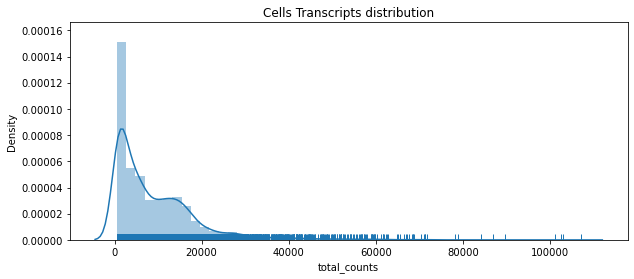

In [40]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['total_counts'], bins=50, rug=True)
title1 = ax.set_title('Cells Transcripts distribution')

Let's zoom in on the distribution by setting a limit on the x-axis. It is easier to see that 2500 could be a reasonable minimum threshold for the total number of transcripts.

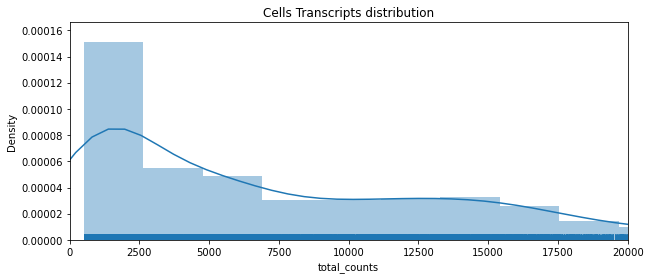

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['total_counts'], bins=50, rug=True)
plt.xlim(0, 20000)
title1 = ax.set_title('Cells Transcripts distribution')

Again we focus on the right area of the plot. Here it is easy to identify a maximum threshold where the tail of the distribution is really low. For example we can choose 35000 total transcripts.

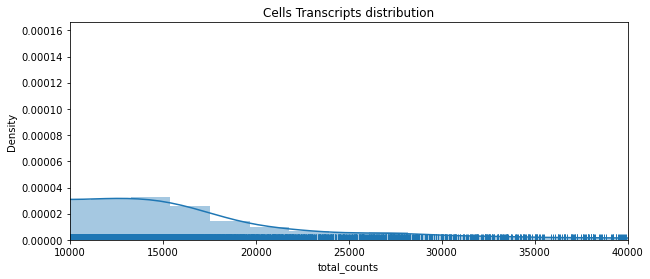

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['total_counts'], bins=50, rug=True)
plt.xlim(10000, 40000)
title1 = ax.set_title('Cells Transcripts distribution')

We do a similar analysis with the thresholds for the number of genes detected in each droplet. 

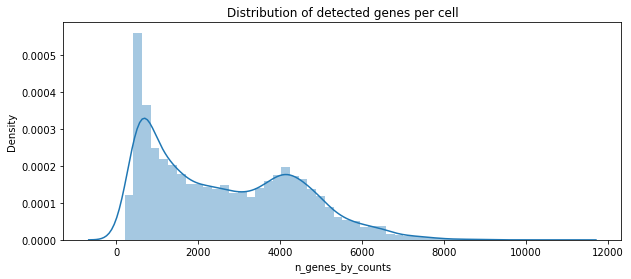

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['n_genes_by_counts'], bins=50)
title1 = ax.set_title('Distribution of detected genes per cell')

Here we can select a minimum threshold of 1000 to remove the lower peak from the distribution, and we can choose a maximum threshold of 7000.

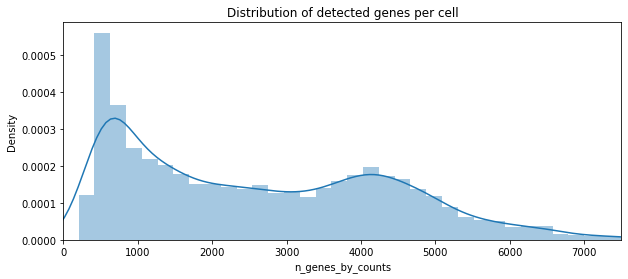

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['n_genes_by_counts'], bins=50)
plt.xlim(0, 7500)
title1 = ax.set_title('Distribution of detected genes per cell')

**Mitochondrial content**: In this dataset there are few cell with a high percentage of mitochondrial content. Those are precisely 245 if we set 0.1 (that is 10%) as a threshold. A value between 10% and 20% is the usual standard when filtering single cell datasets.

In [45]:
#subsetting to see how many cells have percentage of mitochondrial genes above 10%
sample_2[ sample_2.obs['perc_mito']>0.1, : ].shape[0]

245

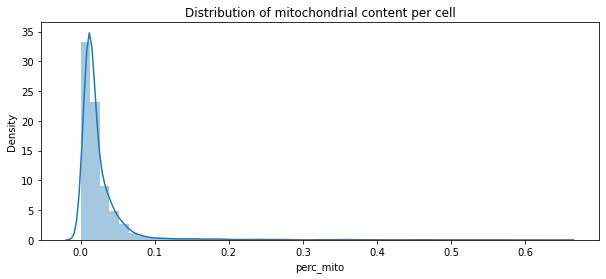

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['perc_mito'], bins=50)
title1 = ax.set_title('Distribution of mitochondrial content per cell')

Zooming in on mitochondrial content

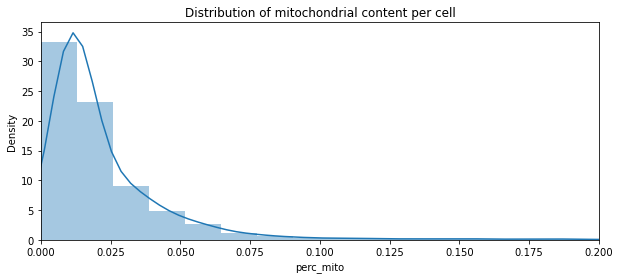

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['perc_mito'], bins=50)
plt.xlim(0, .2)
title1 = ax.set_title('Distribution of mitochondrial content per cell')

**Ribosomal content**: The percentage of ribosomal protein genes is higher than the one for mitochondrial genes. Here there is not a typical threshold, since this can change a lot amongst datasets and their biological characteristics. It is better tio choose a weak threshold when in doubt, for example setting a maximum boundary of 0.3.

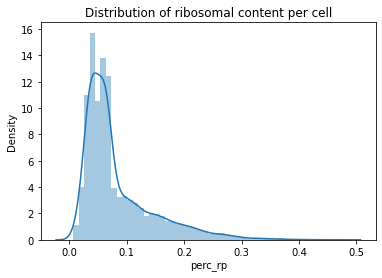

In [48]:
ax = sns.distplot(sample_2.obs['perc_rp'], bins=50)
x = ax.set_title('Distribution of ribosomal content per cell')

We can see how many droplets contain more than 30% of ribosomal protein transcripts

In [49]:
f'Max ribosomal transcript threshold overstepped by {sum(sample_2.obs["perc_rp"]>0.3)} cells'

'Max ribosomal transcript threshold overstepped by 78 cells'

### Bidimensional patterns

**Counts vs Genes:** this is a typical plot, where you look at the total transcripts per cells (x axis) and detected genes per cell (y axis). **Usually, those two measures grow together**. Points with many transcripts where the number of detected genes grows slowly might be multiplets (multiple cells sequenced together as one), while very few transcripts and genes denote the presence of only ambient RNA or very low quality sequencing of a cell. In the two plots below, dots (droplets) are coloured based on the percentage of mitochondrial and ribosomal transcripts. Note how a high proportion of the two percentages (light blue and yellow colour) is often on cells with very low number of transcripts and genes (bottom left corner of the plots).

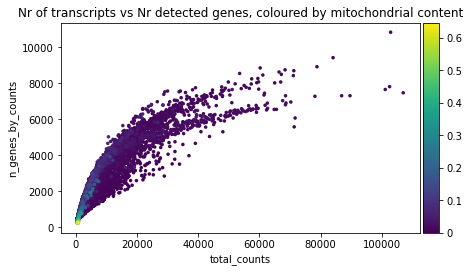

In [50]:
sc.pl.scatter(sample_2, x='total_counts', y='n_genes_by_counts', color='perc_mito', 
              title ='Nr of transcripts vs Nr detected genes, coloured by mitochondrial content',
             size=50)

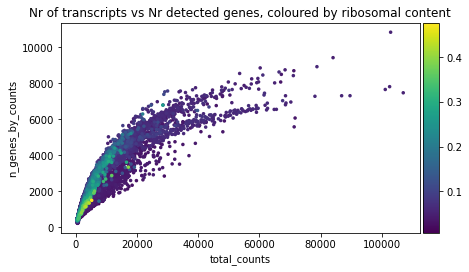

In [51]:
sc.pl.scatter(sample_2, x='total_counts', y='n_genes_by_counts', color='perc_rp', 
              title ='Nr of transcripts vs Nr detected genes, coloured by ribosomal content',
             size=50)

Looking at the bidimensional plots alone makes it hard to find proper thresholds for all the many parameters involved in the quality analysis. This is why we have been looking at many different distributions and relationships between measures before.

### Abnormal amount of transcripts from a gene

Finally, we look at genes whose transcripts are prevalent in the cells of our data. The twenty top genes are in the barplot below. We can see PRM2, PRM1 and PTGDS are on the top three positions. However, those genes are prevalent in cells that are close to be developed spermatozoa, so their presence is not at all alarming in terms of data quality. The same holds for TNP1. Instead, we can take into consideration MALAT1 and the two mitochondrial genes MT-CO1 and MT-CO2, which are expressed at high percentages in many cells. This can be an indicator of cells with too low quality, because it means few genes are expressed while the others have low or zero expression.

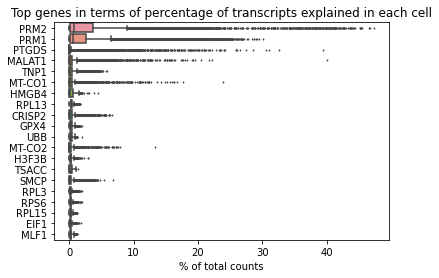

In [52]:
fig, ax = plt.subplots(1,1)
ax.set_title('Top genes in terms of percentage of transcripts explained in each cell')
fig = sc.pl.highest_expr_genes(sample_2, n_top=20, ax=ax)

We save the percentages of transcripts expressing the three genes identified above.

In [53]:
perc_malat = np.sum( sample_2[:,'MALAT1'].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_MALAT1'] = perc_malat.copy()

perc_malat = np.sum( sample_2[:,'MT-CO1'].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_MT-CO1'] = perc_malat.copy()

perc_malat = np.sum( sample_2[:,'MT-CO2'].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_MT-CO2'] = perc_malat.copy()

Note that, when the genes you suspect are indicating low-quality droplets are actually meaningful, you will see that high-percentages of transcripts match other low-quality indicators. For example, let's plot the three percentages defined above against the total amount of detected genes in each cell. You can see how droplets with fewer transcripts have at the same time high-percentages of mRNA from MALAT1, MT-CO1 and MT-CO2. You can use those plots to establish filtering thresholds. Below you can see some suggested thresholds plotted as red lines.

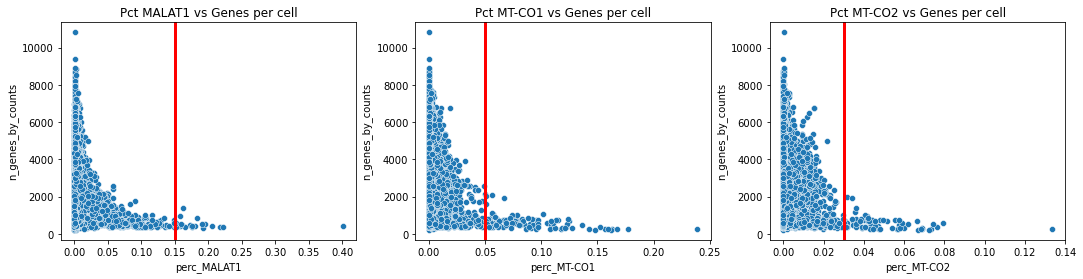

In [54]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

#some thresholds based on the plots below
MALAT1_THR = 0.15
MTCO1_THR = 0.05
MTCO2_THR = 0.03

#ax.set_title('Top genes in terms of percentage of transcripts explained in each cell')
ax[0].set_title('Pct MALAT1 vs Genes per cell')
fig1 = sns.scatterplot( x=sample_2.obs['perc_MALAT1'], y=sample_2.obs['n_genes_by_counts'], ax=ax[0] )
fig1.axvline(x=MALAT1_THR, lw=3, c='r')
ax[1].set_title('Pct MT-CO1 vs Genes per cell')
fig2 = sns.scatterplot( x=sample_2.obs['perc_MT-CO1'], y=sample_2.obs['n_genes_by_counts'], ax=ax[1] )
fig2.axvline(x=MTCO1_THR, lw=3, c='r')
ax[2].set_title('Pct MT-CO2 vs Genes per cell')
fig3 = sns.scatterplot( x=sample_2.obs['perc_MT-CO2'], y=sample_2.obs['n_genes_by_counts'], ax=ax[2] )
fig3.axvline(x=MTCO2_THR, lw=3, c='r')

How many cells would we remove with these thresholds?

In [55]:
#find droplets above one of the thresholds
total = (sample_2.obs['perc_MALAT1']>MALAT1_THR)|(sample_2.obs['perc_MT-CO1']>MTCO1_THR)|(sample_2.obs['perc_MT-CO2']>MTCO2_THR)

#save the identifier into the data
sample_2.obs['genes_threshold_filter'] = pd.Categorical(total).copy()

In [56]:
#count all the cells above thresholds
f'You will filter out in total {sum(total)} cells'

'You will filter out in total 145 cells'

### PCA-based outlier detection

Choosing thresholds is much of a visual exercise, and thus subject to our own feeling of what is a true cell or a droplet not worth including in the data analysis. A good strategy that can be adopted is to **choose quite permissive thresholds and let an automatic procedure finding the remaining outliers** based on quality measures. Here, we calculate the PCA of all available quality measures and find outliers within the PCA projection. This method sometimes fails, especially when your data is of very good or extremely bad quality, selecting an enormous amount of cells as outliers. Thus always look at the diagnostic plots below to see if only a reasonable amount of points is selected as outlying in the data, and if part of those points are already included in other filters. This is an exact reproduction of the PCA filtering implemented in the `scater` package ([McCarthy et al, 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5408845/)), and is based on the robust Donoho-Stahel outlyingness measure statistic ([Rousseeuw et al, 2017](https://arxiv.org/pdf/1608.05012.pdf))

--- PCA of dimension 2 on the following metadata:
['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'perc_rp', 'perc_mito', 'perc_MT-CO1', 'perc_MALAT1', 'perc_MT-CO2']
on a sample with 8583 datapoints
--- Calculate outlyingness on 100 randomly sampled axae, (random seed 42)
--- Found 924 outliers
--- Returned annotated data object containing
--- * adata.obs["SDO_outliers"]: boolean variable identifying outliers
--- * adata.obs["SDO_outlyingness"]: outlyingness of each cell


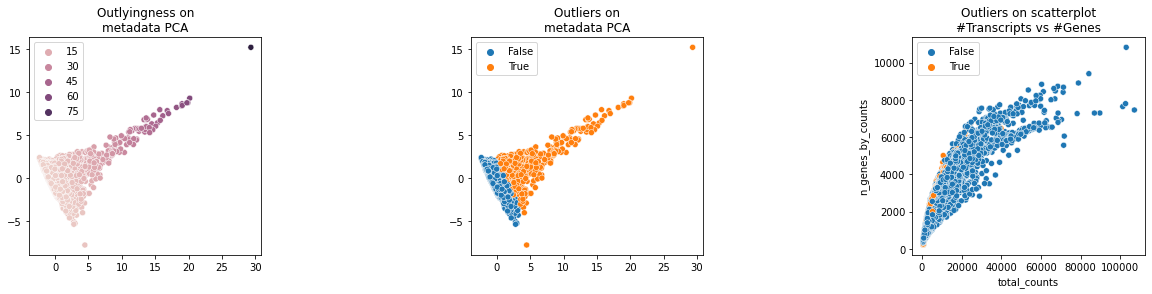

In [57]:
sample_2 = PCAfiltering(adata=sample_2, 
                     obs_subset=['log1p_n_genes_by_counts','log1p_total_counts', 
                                 'pct_counts_in_top_50_genes', 'perc_rp', 'perc_mito',
                                 'perc_MT-CO1', 'perc_MALAT1', 'perc_MT-CO2']) 

The algorithm found 924 outliers. Those are saved in `sample_2.obs["SDO_outliers"]`. Do those match some of the outliers found with the percentages of transcripts from `MALAT1`, `MT-CO1` and `MT-CO2`?

In [58]:
print('Number of outliers both from PCA and genes transcript percentage')
sum( np.bool8(sample_2.obs["SDO_outliers"]) & np.bool8(sample_2.obs["genes_threshold_filter"]) )

Number of outliers both from PCA and genes transcript percentage


128

In [59]:
print('Number of outliers only from PCA')
sum( np.bool8(sample_2.obs["SDO_outliers"]) )

Number of outliers only from PCA


924

In [60]:
print('Number of outliers only from genes transcript percentage')
sum( np.bool8(sample_2.obs["genes_threshold_filter"]) )

Number of outliers only from genes transcript percentage


145

This means that PCA finds outliers that include some of our previous criteria. We can also see in a scatter plot where the PCA-based filtering will remove cells.

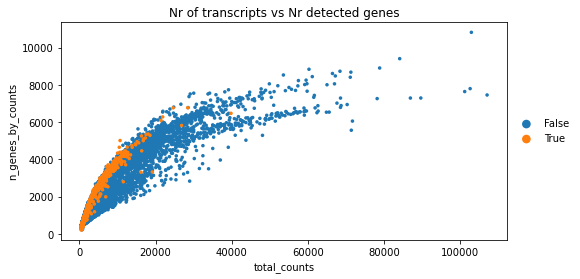

In [61]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

#plot cells filtered by max transcripts
fig1 = sc.pl.scatter(sample_2,
             x='total_counts', y='n_genes_by_counts', color='SDO_outliers', size=50,
              title =f'Nr of transcripts vs Nr detected genes', ax=ax)

## Choosing thresholds and filtering

We now establish all the filtering values discussed until now by looking at distributions.

In [62]:
MIN_COUNTS = 2500  #minimum number of transcripts per cell
MAX_COUNTS = 35000 #maximum number of transcripts per cell
MIN_GENES = 1000   #minimum number of genes per cell
MAX_GENES = 7000   #maximum number of genes per cell
MAX_MITO = .1      #mitochondrial percentage threshold
MAX_RP = .3       #ribosomal percentage threshold

We can also plot all the points we are going to filter out. We save `all_filters` in the data. This contains all filters defined until now to detect points to remove.

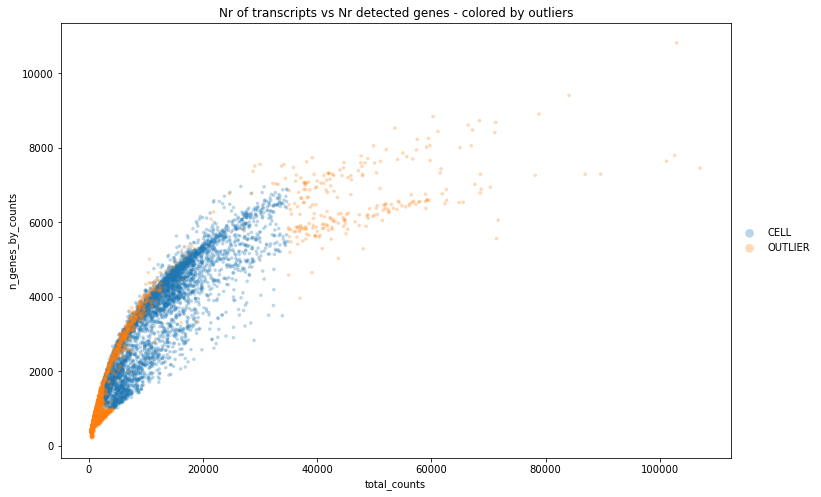

In [63]:
#define an indicator to remove cells
all_filters = (sample_2.obs['total_counts']>MAX_COUNTS) | (sample_2.obs['total_counts']<MIN_COUNTS) | \
              (sample_2.obs['n_genes_by_counts']<MIN_GENES) | (sample_2.obs['n_genes_by_counts']>MAX_GENES) | \
              np.bool8(sample_2.obs['genes_threshold_filter']) | np.bool8(sample_2.obs['SDO_outliers']) | \
              (sample_2.obs['perc_mito']>MAX_MITO) | (sample_2.obs['perc_mito']>MAX_RP)

sample_2.obs['all_filters'] = pd.Categorical(all_filters).rename_categories(['CELL','OUTLIER'])
            
fig, ax = plt.subplots(1,1, figsize=(12,8))

#plot cells filtered by max transcripts
fig1 = sc.pl.scatter(sample_2, alpha=.3,
             x='total_counts', y='n_genes_by_counts', color='all_filters', size=50,
              title =f'Nr of transcripts vs Nr detected genes - colored by outliers', ax=ax, )

**Important**: After filtering, we will normalize the data and plot projections, identify clusters and perform other analysis. In such steps, one might find out that there are groups of low quality data points (for example, large unidentifiable clusters of cells with less transcripts than in all the other clusters). In that case it is good to go back to filtering and be more conservative in choosing threshold parameters.

 
The following commands filter using all the chosen thresholds defined before. Note for the second filtering: the parameter `min_cells` remove all those cells showing transcripts for only 10 genes or less - standard values for this parameter are usually between 3 and 10, and do not come from looking at the QC plots. This is just to remove very rare transcripts that are meaningless in a downstream analysis. Note that this means we will not find clusters of cells containing 10 cells or less.

In [64]:
sample_2 = sample_2[ sample_2.obs['all_filters'] == "CELL" ].copy()

sc.preprocessing.filter_genes(sample_2, min_cells=10)

We can see here the new data size

In [65]:
print(f'Cells after filters: {sample_2.shape[0]}, Genes after filters: {sample_2.shape[1]}')

Cells after filters: 5050, Genes after filters: 24576


## Doublet filtering

Another important step consists in filtering out doublets (and triplets, quadruplets, ..., multiplets). In single-cell RNA sequencing (scRNA-seq) data, doublets and multiplets refer to cells that contain the transcriptional profiles of two or more distinct cells. Doublets and multiplets can occur during the cell dissociation process or when two or more cells are captured in the same droplet during the library preparation step.

Doublets and multiplets can cause issues in scRNA-seq data analysis, as they can confound downstream analyses, such as cell clustering and differential gene expression analysis. Therefore, it is important to identify and remove doublets and multiplets from scRNA-seq data.
Note that the almost totality of multiplets are doublets, because triplets and above are extremely rare for technical reasons. Read [this more technical blog post](https://liorpachter.wordpress.com/2019/02/07/sub-poisson-loading-for-single-cell-rna-seq/) for more explanations.



Here we use the tool `scrublet` ([Wolock et al, 2019](https://www.biorxiv.org/content/10.1101/357368v1)) to detect doublets and filter them out. `Scrublet` is a popular package in Python for identifying doublets in scRNA-seq data. Scrublet uses a nearest-neighbor approach to identify putative doublets based on their similarity to each other. Specifically, it uses a k-nearest neighbor classifier to predict the likelihood that each cell is a doublet. `Scrublet` works by computing a doublet score for each cell in the dataset, which reflects the likelihood that the cell is a doublet. Cells with high doublet scores are more likely to be doublets, while cells with low doublet scores are more likely to be singlets. 

![](https://ars.els-cdn.com/content/image/1-s2.0-S2405471218304745-fx1.jpg)

*Figure: the `scrublet` working principle, from ([Wolock et al, 2019](https://www.biorxiv.org/content/10.1101/357368v1))*

Below, we run `scrublet` on the data. The package has an interface in `scanpy` and is straightforward to use. As a required parameter, you have to insert the expected doublet rate. A rule of thumb is to choose 6% as a typical rate, because is the value in between the possible doublet rates depending on how many cells are loaded in a single cell experiment. Otherwise, you can have a look at this table to see what is the expected doublet rate for different amounts of cells loaded in a single cell 10X experiment. In our case, each sample ranges somewhere between 3000 and 8000 cells, so one could use 3% as a possible guess.

![](img/doubletstable.png)

*Figure: doublet rates for various setting in a single cell experiment with 10X technology.*

In [67]:
 sc.external.pp.scrublet(sample_2, 
                        expected_doublet_rate=0.04,
                        random_state=12345)

Automatically set threshold at doublet score = 0.34
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 42.2%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 2.4%


In the code above, `random_state` is a number choosing how the simulations are done. Using a specific random state means that you will always simulate the same doublets whenever you run this code. This allows you to reproduce exactly the same results every time and is a great habit to have for reproducibility in your own research.

It seems that the doublet rate is likely to be lower than 4%, meaning that the dissociation protocol has been executed carefully. We now plot the doublet scores assigned to each cell by the algorithm. We can see that most cells have a low score (the score is a value between 0 and 1). A score of 1 means a data point is a perfect doublet as from simulations. Datasets with many doublets show a more bimodal distribution (look for example at [this example](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) from the `scrublet` tutorial), while here we just have a light tail beyond 0.1. 

<AxesSubplot:xlabel='doublet_score', ylabel='Density'>

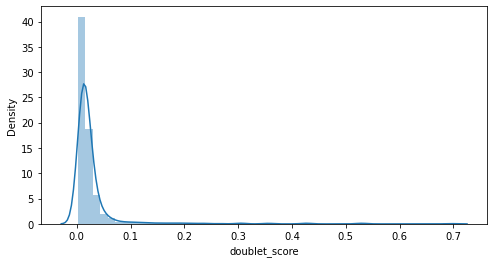

In [69]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

sns.distplot(sample_2.obs['doublet_score'])

We can choose 0.1 as filtering threshold for the few detected doublets or alternatively use the automatic selection of doublets by the algorithm. The automatic choice is not always very good, and works when there are two clear peaks in the histogram. Therefore it is often better to look at the histogram and choose manually a threshold.

In [70]:
sample_2 = sample_2[ sample_2.obs['doublet_score']<0.1 ].copy()

In [71]:
print(f'Cells after filters: {sample_2.shape[0]}, Genes after filters: {sample_2.shape[1]}')

Cells after filters: 4843, Genes after filters: 24576


# Biological features, Technical features and how to navigate through them

Biologically similar cells are not necessarily directly comparable in a scRNA-seq dataset because of different features. One type of feature is of technical nature. Technical features are all those sources of variations in the dataset that are not related to the biology of the sample, and which can bias or confuse the changes in the data due to biological signals. Typical sources of technical features are: 

* the different percentage of captured transcripts per cell (capture efficiency), 
* the presence of technical replicates (batch effect), 
* the introduction of noisy, low quality and high quality transcripts.

The capture efficiency can be influenced by many factors, i.e. the different transcript tags leading to different capture efficiency, the type of protocol used in the laboratory, the amount of PCR performed on different transcripts. 

Biological features might as well alter the transcript proportion in a cell, for example in case of different points in the cell cycles altering the expression of specific genes. In some cases it is beneficial to remove the effect of some features, but only when it is allowed by precise biological background knowledge.

To avoid technical signals covering biological information, a good filtering is always the starting point. Afterwards, a normalization approach is needed. Normalization is one of the main topics of scRNAseq data preprocessing, and many advanced techniques take into account the statistical distribution of counts and the presence of technical/biological features of interest ([Lytal et al, 2020](https://www.frontiersin.org/articles/10.3389/fgene.2020.00041/full)).

The most standard approach is the TMP (Transcript Per Million) normalization ([In and Pincket, 2022](https://arxiv.org/abs/2205.02844)). Here, the transcripts is each cell are rescaled by a factor such that the transcripts in each cell sum to the same value. After TPM rescaling, the data is usually logarithmized, so that a transcript $x$ becomes $log(x+1)$. Logarithmization is known to further reducing, together with normalization, the technical bias induced by the different amount of data in each cell ([Lytal et al, 2020](https://www.frontiersin.org/articles/10.3389/fgene.2020.00041/full)). Finally, the data is standardized with mean 0 and variance 1. This is necessary since the PCA assumes implicitly that datapoints are normally distributed ((Townes et al, 2019)[https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6]).

As a rule of thumb, TPM works fine in absence of multiple samples, but is still problematic because does not take into account the statistical properties of the data, therefore a certain amount of technical biases is not removed by this method. It is possible to use more advanced methods for considering the distribution of the transcripts, technical and biological covariates as part of a statistical model for the transcripts. One of the current state-of-the-art method is scTransform ((Hafemeister and Satija, 2019)[https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1]). This is currently implemented in `R`.

`scTransform` is a software package for normalizing single-cell RNA sequencing data that can correct for technical sources of variation and remove batch effects. It applies a variance-stabilizing transformation to the raw count data and models the relationship between the mean and variance of the transformed data to estimate a normalization factor for each cell. Additionally, scTransform uses a statistical framework to estimate the biological variance and differential expression across cells. One of the key advantages of scTransform is that it can be applied to datasets with any number of samples or conditions and can normalize data across multiple batches or sequencing runs. Another advantage is that it can estimate biological variability in addition to technical noise, which is important for downstream analysis such as identifying differentially expressed genes.

## TPM normalization and its effect on technical biases

Before normalizing we look at the highest correlation between the PCA of the raw data and some technical features. The first component of the PCA has the highest R2 when correlated with the total amount of transcripts. PC5 is mostly correlated with the amount of mitochondrial transcripts. This means that the two PC components mostly describe variations in the technical features and misses the description of biological variation. We will see after normalization that these correlations are reduced. Note that we are plotting the correlations for one specific sample, meaning batch effect is absent.

The resulting plots say that there is some correlation with the total number of transcripts per cell. This is usual in scRNA-seq data, and normalizing with TPM should remove this bias. Other technical biases have already been greatly reduced by filtering.

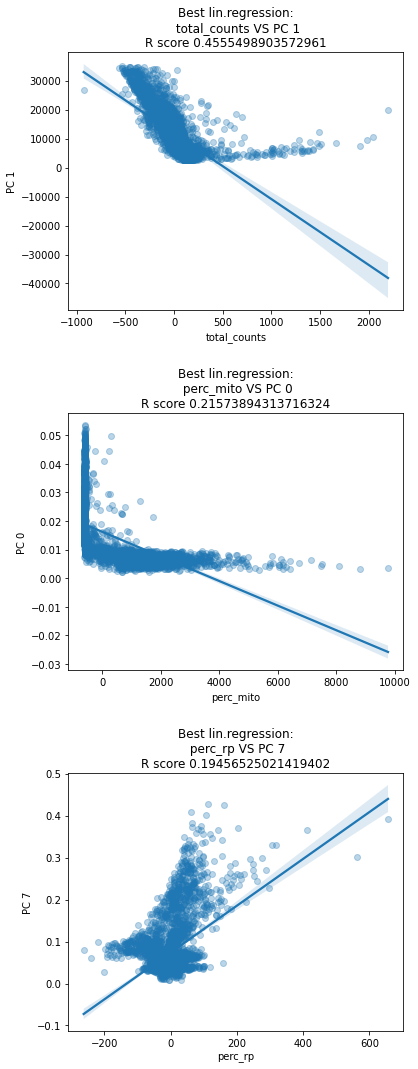

In [72]:
#PCA on unnormalized data
sc.preprocessing.pca(sample_2, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=sample_2, obs_subset=['total_counts','perc_mito','perc_rp'])

Here we execute the normalization steps. We use the standard TPM normalization and evaluate the result looking at the data projections later on. We select also the most variable genes to avoid considering genes that have very constant expression across all the dataset, and are therefore not informative. The most variable genes are used to create the PCA projection of the data, and we can use them also in other parts of the analysis.

In [73]:
# save raw data matrix
sample_2.layers['raw_counts'] = sample_2.X.copy()
# TPM normalization
sc.pp.normalize_per_cell(sample_2)
# matrix logarithmization
sc.pp.log1p(sample_2)
# most variable genes
sc.pp.highly_variable_genes(sample_2, n_top_genes=15000)
#scale
sc.pp.scale(sample_2)
sample_2.layers['scaled_counts'] = sample_2.X.copy()

We check again the correlation between PCA components and technical features. Now the relationship with total transcripts has been disrupted by normalization. There seems to be however a stronger relationship with the percentage of mitochondrial transcripts! Such relationship was probably present before, but the TPM method has actually exacerbated it, since it takes into account only the depth of each cell, and not other characteristics. In the following notebook, we will normalize the data taking into account additional sources of variation.

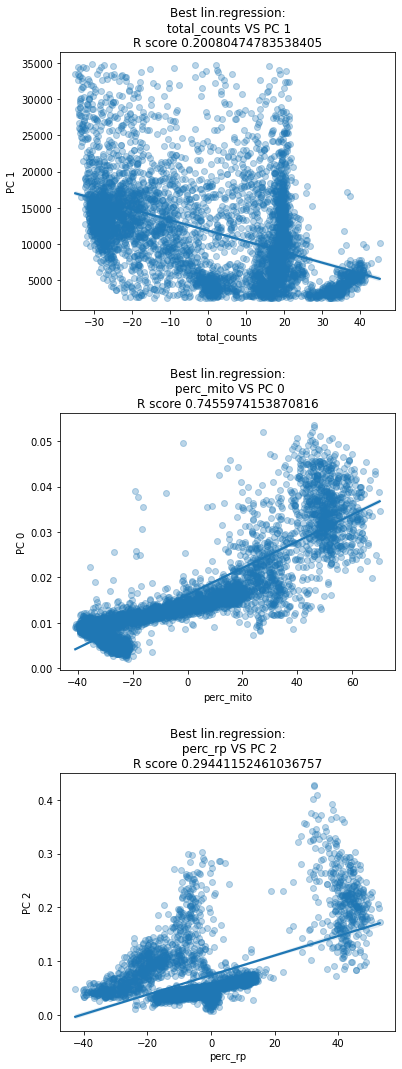

In [74]:
#PCA on unnormalized data
sc.preprocessing.pca(sample_2, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=sample_2, obs_subset=['total_counts','perc_mito','perc_rp'])

# Visual Evaluation of your data

A quite basic but easy way to look at the results of our filtering is to normalize and plot the dataset on some projections. Here we use a standard normalization technique that consists of:
- **TPM normalization**: the transcripts of each cell are normalized, so that their total amounts to the same value in each cell. This should make cells more comparable independently of how many transcripts has been retained during cell isolation.
- **Logarithmization**: the logarithm of the normalized transcripts is calculated. This reduce the variability of transcripts values and highlights variations due to biological factors.
- **Standardization**: Each gene is standardized across all cells. This is useful for example  for projecting the data onto a PCA. 

Do not worry about these steps, we will explain them in more detail in the next lessons

In [225]:
# TPM normalization and storage of the matrix
#sc.pp.normalize_per_cell(sample_2)
#sample_2.layers['umi_tpm'] = sample_2.X.copy()

# Logarithmization and storage
#sc.pp.log1p(sample_2)
#sample_2.layers['umi_log'] = sample_2.X.copy()

# Select some of the most meaningful genes to calculate the PCA plot later
# This must be done on logarithmized values
sc.pp.highly_variable_genes(sample_2, n_top_genes=2000)

# save the dataset
sample_2.write('../../Data/notebooks_data/sample_2.filt.h5ad')

# standardization and matrix storage
#sc.pp.scale(sample_2)
sample_2.layers['umi_gauss'] = sample_2.X.copy()

Now we calculate the PCA projection

In [226]:
sc.preprocessing.pca(sample_2, svd_solver='arpack', random_state=12345)

We can look at the PCA plot and color it by some quality measure and gene expression. We can already see how the PCA has a clear structure with only a few dots sparsed around. It seems the filtering has got a good result.

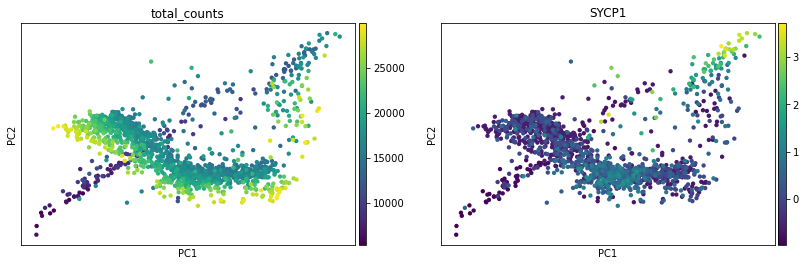

In [227]:
sc.pl.pca(sample_2, color=['total_counts','SYCP1'])

We plot the variance ratio to see how each component of the PCA changes in variability. Small changes in variability denote that the components are mostly modeling noise in the data. We can choose a threshold (for example 15 PCA components) to be used in all algorithms that use PCA to calculate any quantity.

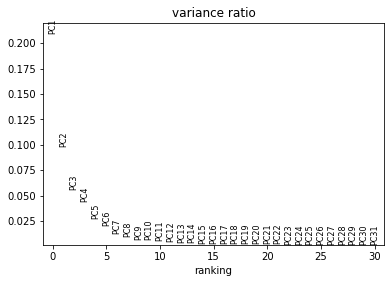

In [228]:
sc.plotting.pca_variance_ratio(sample_2)

We project the data using the UMAP algorithm. This is very good in preserving the structure of a dataset in low dimension, if any is present. We first calculate the neighbors of each cell (that is, its most similar cells), those are then used for the UMAP. The neighbors are calculated using the PCA matrix instead of the full data matrix, so we can choose the number of PCA components to use (parameter `n_pcs`). Many algorithms work on the PCA, so you will see the parameter used again in other places.

In [229]:
sc.pp.neighbors(sample_2, n_pcs=15, random_state=12345)

In [230]:
sc.tools.umap(sample_2, random_state=54321)

The UMAP plot gives a pretty well-structured output for this dataset. We will keep working further with this filtering.

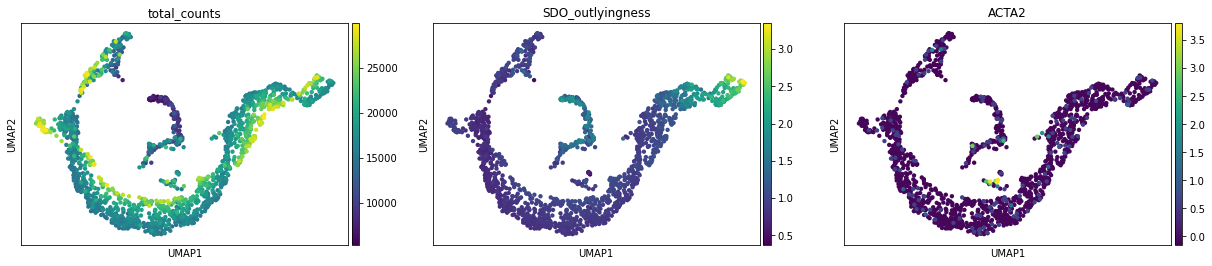

In [231]:
sc.plotting.umap(sample_2, color=['total_counts','SDO_outlyingness', 'ACTA2'])

In [232]:
sample_2.write('../../Data/notebooks_data/sample_2.filt.norm.h5ad')

-------------------------------

## Wrapping up

We have succesfully gone through the filtering of a single cell dataset with good results that can be used further in the data analysis. In the next notebook Normalize and Integrate, we will integrate this dataset (testis cells from a healthy adult man) with the same type of sample from another man. Filtering of the other dataset is in the notebook `Part02_filtering_sample3.ipynb`. **Run the notebook to generate the filtered dataset**. The procedure follows tightly what happens for the dataset we just filtered.

-------------

**Optional:** 

As you could see, this dataset seemed pretty ok to handle. There is another dataset of much lower quality, but will not be integrated in the coming data analysis. Its preprocessing is shown as the submenu `Filtering a low quality sample` in the section `Extra` of the course webpage. In it, we will also show an aggressive filtering workflow using a combination of PCA and automatic outliers detection. Feel free to explore it!